# [Lecture 13 - Multilevel Adventures](https://www.youtube.com/watch?v=sgqMkZeslxA)

In [1]:
%run init_notebook.py

Module aliases imported by init_notebook.py:
--------------------------------------------
import numpy as np

import pandas as pd

import statsmodels.formula.api as smf

import pymc as pm

import xarray as xr

import arviz as az

import utils as utils

from scipy import stats as stats

from matplotlib import pyplot as plt

Watermark:
----------
Last updated: 2023-09-05T18:10:37.732166-07:00

Python implementation: CPython
Python version       : 3.10.12
IPython version      : 8.14.0

Compiler    : Clang 15.0.7 
OS          : Darwin
Release     : 22.2.0
Machine     : arm64
Processor   : arm
CPU cores   : 10
Architecture: 64bit

statsmodels: 0.14.0
pandas     : 2.0.3
matplotlib : 3.7.1
arviz      : 0.16.1
xarray     : 2023.8.0
scipy      : 1.11.2
pymc       : 5.7.2
numpy      : 1.25.2



# Review: Drawing the Bayesian Owl 🦉

1. Establish **Estimand**
2. Build **Scientific model(s)** (i.e. Causal model), depending on 1.
3. Use 1 & 2 to build a **Statistical Model**
4. **Simulate** data from from 2 and **Validate** you can recover from 3
5. **Analyze Real Data** using 3.

In real life, it's never a linear path; you are jumping back and forth, iterating on 2-5, much like a branching path/choose your own adventure book.

# Multi-level Adventures
Similarly there is no one-size-fits all approach to applying the methods in this course. In order to optimize for success when applying these methods, McElreath suggests a few strategies ("paths") moving forward:

- **Return to the start** -- McElreath suggests to return to the beginning of the course, reviewing the material now that you've observed a lion's share of the building blocks.
  - **It turns out that the notes presented in this repo are after the _Third Pass of the course_. I can't recommend strongly enough to take McElreath's advice and review the material from the beginning.** It's a lot of material, but I was flabbergasted with how much I had forgotten in the short time between this lecture and the earlier ones. Similarly, I was surprised by how much easier it was to soak up the material the 2nd time around--a real testament to McElreath's outstanding teaching style.
- **Skim & Index** -- don't sweat the deatils, just aquaint yourself with the possiblities.
  - One thing that I've found useful is to compile each of the model classes discussed in the course into a "recipe book" or "toolbox" of plug-and-play models that can be reused for different applications
  
  
# Clusters vs Features

$$
\begin{align*}
\textbf{Clusters}& && &\textbf{Features} \\
tanks& &\longrightarrow& &survival \\
stories& &\longrightarrow& & treatment\;effect \\
individuals& &\longrightarrow& & average\;response \\
departments& &\longrightarrow& & admission\;rate \\
\end{align*}
$$

- **Clusters**: subgroups in the data (e.g. tanks, participants, stories, departments)
  - **Adding clusters is fairly simple**
    - requires more index variables; more population priors
- **Features**: aspects of the model (i.e. parameters) that vary by cluster (e.g. survival, average response rate, admission rate, etc.)
  - **Adding features requires more complexity**
    - more parametrers, particularly dimensions in each population prior

## Varying effects as confounds
- **Varying effect strategy**: using **repeat observations** and **partial pooling** to estimate unmeasured features of clusters that have left an imprent on the data
- **Predictive perspective**: regularization
- **Causal Perspective**: unobserved confounds are terrifying, but leveraging repeat observations give us some hope at more accurate inference

### Previous Examples:
#### Grandparents & Education

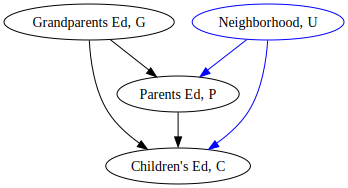

In [2]:
utils.draw_causal_graph(
    edge_list=[
        ("G", "P"),
        ("G", "C"),
        ("P", "C"),
        ("U", "P"),
        ("U", "C")
    ],
    node_props={
        "G": {"label": "Grandparents Ed, G"},
        "P": {"label": "Parents Ed, P"},
        "C": {"label": "Children's Ed, C"},
        "U": {"label": "Neighborhood, U", "color": "blue"}
    },
    edge_props={
        ("U", "P"): {"color": "blue"},
        ("U", "C"): {"color": "blue"}
    }
)

- Neighborhood is a backdoor path confound that blocks mediation analysis of the **direct effect** of $G$ on $C$
- but having repeat observations for neighborhoods U allows us to estimate the effects of this confound

### Trolley Problem Example

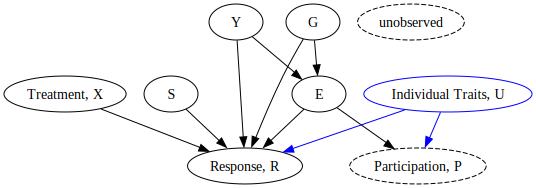

In [3]:
utils.draw_causal_graph(
    edge_list=[
        ("X", "R"),
        ("S", "R"),
        ("E", "R"),
        ("G", "R"),
        ("Y", "R"),
        ("U", "R"),
        ("G", "E"),
        ("Y", "E"),
        ("E", "P"),
        ("U", "P")
    ],
    node_props={
        "X": {"label": "Treatment, X"},
        "R": {"label": "Response, R"},
        "P": {"label": "Participation, P", "style": "dashed"},
        "U": {"label": "Individual Traits, U", "color": "blue"},
        "unobserved": {"style": "dashed"}
    },
    edge_props={
        ("U", "P"): {"color": "blue"},
        ("U", "R"): {"color": "blue"}
    }
)

- Individuals vary on how they react to the response scale, adding noise to our estimatates
- However, given that each participant has repeat observations, we use the repeats to estimate this noise.
- Similarly, individual traits may cause sampling bias through an unobserved participation node; we can use mixed effects to help address this sampling bias.

### Fixed Effect Approach
- rather than partial pooling, **no pooling**.
- very few benefits to using fixed effects over varying reffects.
  - e.g. less efficient
- **focus on getting the story straight** (generative model, causal graph), you can worry about the details of estimator efficiency, etc. later

### Practical Difficulties

- **Varying effects models are always a good default**, but
  1. how do you use more than one cluster
  2. Predictions is at the level of the hierarchy now, which level do we care about
  3. Sampling efficiency -- e.g. centered/non-centered priors
  4. Group-level confounding -- e.g. Full Luxury Bayes or Mundlak Machines. For details, see the BONUS section of [Lecture 12 - Multilevel Models](<Lecture 12 - Multilevel Models.ipynb>)

# Fertility & Behavior in Bangladesh
- 1989 Fertility Survey
- 1924 women, 61 districts
- **Outcome, $C$:** contraceptive use (binary variable)
- **Predictors**: age, $A$ # of living children $K$, urban/rural location $U$
- **Potential (unobserved) confounds**: Family traits, $F$
- **District ID**: $D$

In [4]:
FERTILITY = utils.load_data("bangladesh")
FERTILITY.head()

,woman,district,use.contraception,living.children,age.centered,urban
0,1,1,0,4,18.4400,1
1,2,1,0,1,-5.5599,1
2,3,1,0,3,1.4400,1
3,4,1,0,4,8.4400,1
4,5,1,0,1,-13.5590,1


### Competing causes

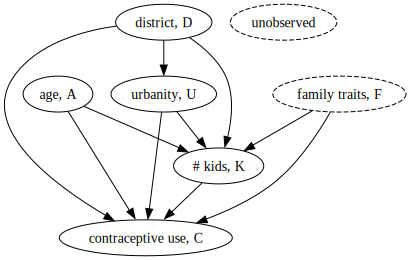

In [5]:
utils.draw_causal_graph(
    edge_list=[
        ("A", "C"),
        ("K", "C"),
        ("U", "C"),
        ("D", "C"),
        ("D", "U"),
        ("U", "K"),
        ("A", "K"),
        ("D", "K"),
        ("F", "C"),
        ("F", "K")
    ],
    node_props={
        "A": {"label": "age, A"},
        "K": {"label": "# kids, K"},
        "U": {"label": "urbanity, U"},
        "D": {"label": "district, D"},
        "C": {"label": "contraceptive use, C"},
        "F": {"label": "family traits, F", "style": "dashed"},
        "unobserved": {"style": "dashed"}
    }
)

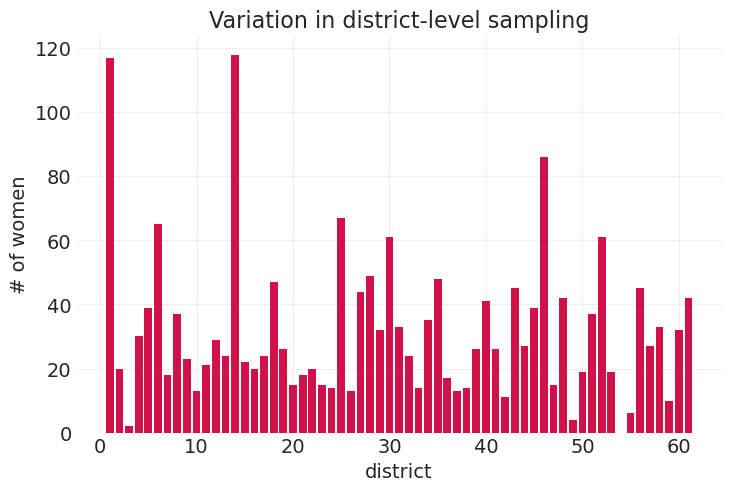

In [6]:
district_counts = FERTILITY.groupby('district').count()['woman']
plt.bar(district_counts.index, district_counts);
plt.xlabel("district")
plt.ylabel("# of women")
plt.title("Variation in district-level sampling");

## Start simple: varying districts
- **Estimand**: contraceptive use in each district; partially pooled
- **Model**:
  - varying intecept/offset for each district

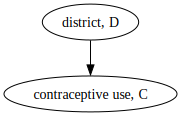

In [7]:
utils.draw_causal_graph(
    edge_list=[
        ("D", "C"),
    ],
    node_props={
        "D": {"label": "district, D"},
        "C": {"label": "contraceptive use, C"},
    }
)


$$
\begin{align*}
C_i &\sim \text{Bernoulli}(p_i) &\text{Contraception use is 0/1 outcome} \\
\text{logit}(p_i) &= \alpha_{D[i]} &\text{log odds of C=1} \\
\alpha_j &\sim \text{Normal}(\bar \alpha, \sigma) &\text{prior for districts; regularizer} \\
\bar \alpha &\sim \text{Normal}(0, 1) &\text{average district} \\
\sigma &\sim \text{Exponential}(1) &\text{std. dev amongst districts}
\end{align*}
$$


In [8]:
USES_CONTRACEPTION = FERTILITY['use.contraception'].values.astype(int)
DISTRICT_ID, _ = pd.factorize(FERTILITY.district)
DISTRICT = np.arange(1, 62).astype(int)  # note: district 54 has no data so we create it's dim by hand

with pm.Model(coords={"district": DISTRICT}) as district_model:
    # Priors
    ## Global priors
    sigma = pm.Exponential('sigma', 1)  # variation amongst districts
    alpha_bar = pm.Normal("alpha_bar", 0, 1)  # the average district
    
    # District-level priors
    alpha = pm.Normal('alpha', alpha_bar, sigma, dims="district")

    # p(contraceptive)
    p_C = pm.Deterministic("p_C", pm.math.invlogit(alpha), dims='district')
    
    # Likelihood
    p = pm.math.invlogit(alpha[DISTRICT_ID])
    C = pm.Bernoulli("C", p=p, observed=USES_CONTRACEPTION)
    
    district_inference = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, alpha_bar, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.


In [9]:
def plot_survival_posterior(
    inference, sigma=None, color='C0', var='p_C', hdi_prob=.89, data_filter=None, title=None, ax=None
):
    
    if ax is None:
        _, ax = plt.subplots(figsize=(10, 4))
        
    def reorder_missing_district_param(vec):
        """
        It appears that pymc tacks on the estimates for district with no data
        (54) onto the end of the parameter vector, so we put it into the correct
        position with this closure
        """
        vec_ = vec.copy()
        end = vec_[-1]  # no data is district 54 (index 53)
        vec_ = np.delete(vec_, -1)
        vec_ = np.insert(vec_, 52, end)
        return vec_
    
    # Filter the dataset for urban/rural if requested
    if data_filter == 'urban':
        data_mask = (FERTILITY.urban).astype(bool)
    elif data_filter == 'rural':
        data_mask = (1 - FERTILITY.urban).astype(bool)
    else:
        data_mask = np.ones(len(FERTILITY)).astype(bool)
        
    plot_data = FERTILITY[data_mask]
    district_counts = plot_data.groupby('district').count()['woman']
    contraceptive_counts = plot_data.groupby('district').sum()['use.contraception']
    proportion_contraceptive = contraceptive_counts / district_counts
    
    plt.sca(ax)
    utils.plot_scatter(
        xs=proportion_contraceptive.index,
        ys=proportion_contraceptive.values,
        color='k', s=50, zorder=3, alpha=.8, label='raw proportions'
    )
    
    # Posterior per-district mean survival probability
    posterior_mean = inference.posterior.mean(dim=('chain', 'draw'))[var]
    posterior_mean = reorder_missing_district_param(posterior_mean.values)

    utils.plot_scatter(DISTRICT, posterior_mean, color=color, zorder=50, alpha=.8, label='posterior means')
    
    # Posterior HDI error bars
    hdis = az.hdi(
        inference.posterior,
        var_names=var,
        hdi_prob=hdi_prob
    )[var].values

    
    error_upper = reorder_missing_district_param(hdis[:, 1]) - posterior_mean
    error_lower = posterior_mean - reorder_missing_district_param(hdis[:, 0])
    utils.plot_errorbar(
        xs=DISTRICT,
        ys=posterior_mean,
        error_lower=error_lower,
        error_upper=error_upper,
        colors=color,
        error_width=8
    )
    
    # Add empirical mean
    empirical_mean = FERTILITY[data_mask]['use.contraception'].mean()
    plt.axhline(y=empirical_mean, c='k', linestyle="--", label='global mean')
        
    plt.ylim([-0.05, 1.05])
    plt.xlabel("district ")
    plt.ylabel("prob. use contraception")
    plt.title(title)
    plt.legend();

#### District-only model posterior predictions

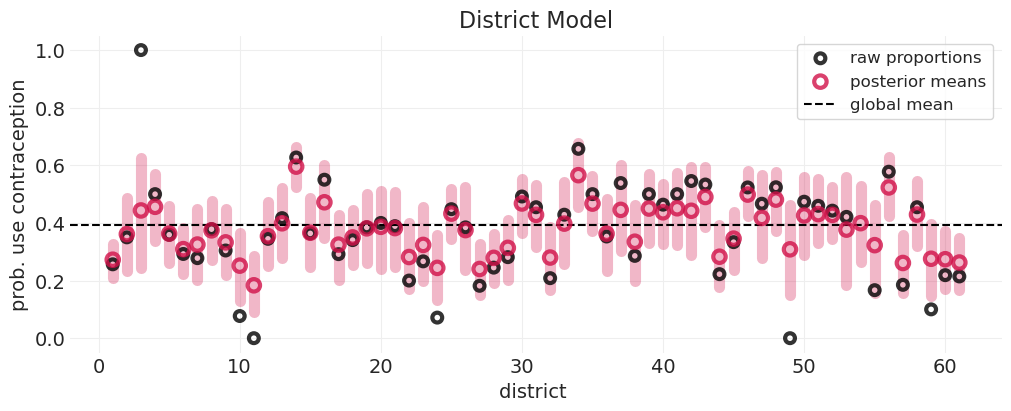

In [10]:
plot_survival_posterior(district_inference, title='District Model')

### Studying the posterior graph

Districts with small sample sizes (e.g. district 3) have

- larger error bars -- exhibiting more uncertainty estimate
- exhibit more shrinkage
  - posteriors are pulled toward the global mean (dashed line)
  - red circles are far from black circles) b.c. the model is less confident
 
Districts with large sample sizes (e.g. district 1) have

- smaller error bars -- more certainty about estimates
- less shrinkage
  - posteriors are closer to the empirical observations for the district
 
Districts with no data (e.g. district 49) still have posteriors

- informed posterior from partial pooling
- mean is near globla mean
- error bars larger than for other districts (looks like i may have an indexing bug in my errorbar code--need to look into that)

## Varying districs + urban

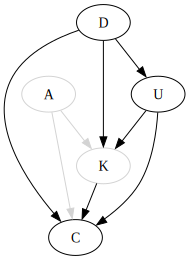

In [11]:
utils.draw_causal_graph(
    edge_list=[
        ("A", "C"),
        ("K", "C"),
        ("U", "C"),
        ("D", "C"),
        ("D", "U"),
        ("U", "K"),
        ("A", "K"),
        ("D", "K")
    ],
    node_props={
        "A": {"color": "lightgray"},
        "K": {"color": "lightgray"},
    },
    edge_props={
        ("A", "K"): {"color": "lightgray"},
        ("A", "C"): {"color": "lightgray"}
    }
)

- What is the effect of urban living?
- Beware:
  - district features have potential group-level confounds
  - Total effect of $U$ passes through $K$
  - Do not stratify by $K$ -- it's a collider, that opens up the district-level confound through $D$

### Statistical Model

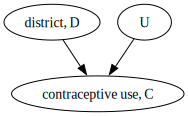

In [12]:
utils.draw_causal_graph(
    edge_list=[
        ("D", "C"),
        ("U", "C"),
    ],
    node_props={
        "D": {"label": "district, D"},
        "C": {"label": "contraceptive use, C"},
    }
)

$$
\begin{align*}
C_i &\sim \text{Bernoulli}(p_i) \\
\text{logit}(p_i) &= \alpha_{D[i]} + \beta_{D[i]} U_i  &\text{include urban effect}\\
\alpha_j &\sim \text{Normal}(\bar \alpha, \sigma) &\text{regularizing prior for district}\\
\bar \alpha &\sim \text{Normal}(0, 1)  &\text{district average prior} \\
\sigma &\sim \text{Exponential}(1) &\text{district std prior} \\
\beta_j &\sim \text{Normal}(\bar \beta, \tau) &\text{regularizing prior for urban effect} \\
\bar \beta &\sim \text{Normal}(0, 1) &\text{urban average prior} \\
\tau &\sim \text{Exponential}(1) &\text{urban std prior}
\end{align*}
$$

### Fit the district-urban model
We use the non-centered prior version here -- details about non-centered will be discussed later

In [13]:
URBAN_CODED, URBAN = pd.factorize(FERTILITY.urban, sort=True)

with pm.Model(coords={"district": DISTRICT}) as district_urban_model:
    
    # Mutable data
    urban = pm.MutableData("urban", URBAN_CODED)
    
    # Priors
    # District offset
    alpha_bar = pm.Normal("alpha_bar", 0, 1)  # the average district
    sigma = pm.Exponential('sigma', 1)  # variation amongst districts
    
    # Uncentered parameterization
    z_alpha = pm.Normal("z_alpha", 0, 1, dims='district')
    alpha = alpha_bar + z_alpha * sigma
    
    # District / urban interaction
    beta_bar = pm.Normal("beta_bar", 0, 1)  # the average urban effect
    tau = pm.Exponential('tau', 1)  # variation amongst urban
    
    # Uncentered parameterization
    z_beta = pm.Normal("z_beta", 0, 1, dims='district')
    beta = beta_bar + z_beta * tau

    # Recored p(contraceptive)
    p_C = pm.Deterministic("p_C", pm.math.invlogit(alpha + beta))
    p_C_urban = pm.Deterministic("p_C_urban", pm.math.invlogit(alpha + beta))
    p_C_rural = pm.Deterministic("p_C_rural", pm.math.invlogit(alpha))
    
    # Likelihood
    p = pm.math.invlogit(alpha[DISTRICT_ID] + beta[DISTRICT_ID] * urban)
    C = pm.Bernoulli("C", p=p, observed=USES_CONTRACEPTION)
    
    district_urban_inference = pm.sample(target_accept=.95)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha_bar, sigma, z_alpha, beta_bar, tau, z_beta]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 13 seconds.


#### Summarize the urban-district posterior

In [14]:
az.summary(district_urban_inference, var_names=['alpha_bar', 'beta_bar', 'tau', 'sigma'])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha_bar,-0.697,0.091,-0.860,-0.519,0.002,0.001,3434.0,3136.0,1.0
beta_bar,0.618,0.153,0.333,0.900,0.002,0.002,5172.0,3311.0,1.0
tau,0.543,0.213,0.135,0.957,0.007,0.005,980.0,878.0,1.0
sigma,0.483,0.088,0.331,0.658,0.002,0.002,1490.0,2457.0,1.0


#### Compare posterior predictive for urban/rural form single model fit jointly

saving figure to images/fertility_posterior_means_rural_urban.png


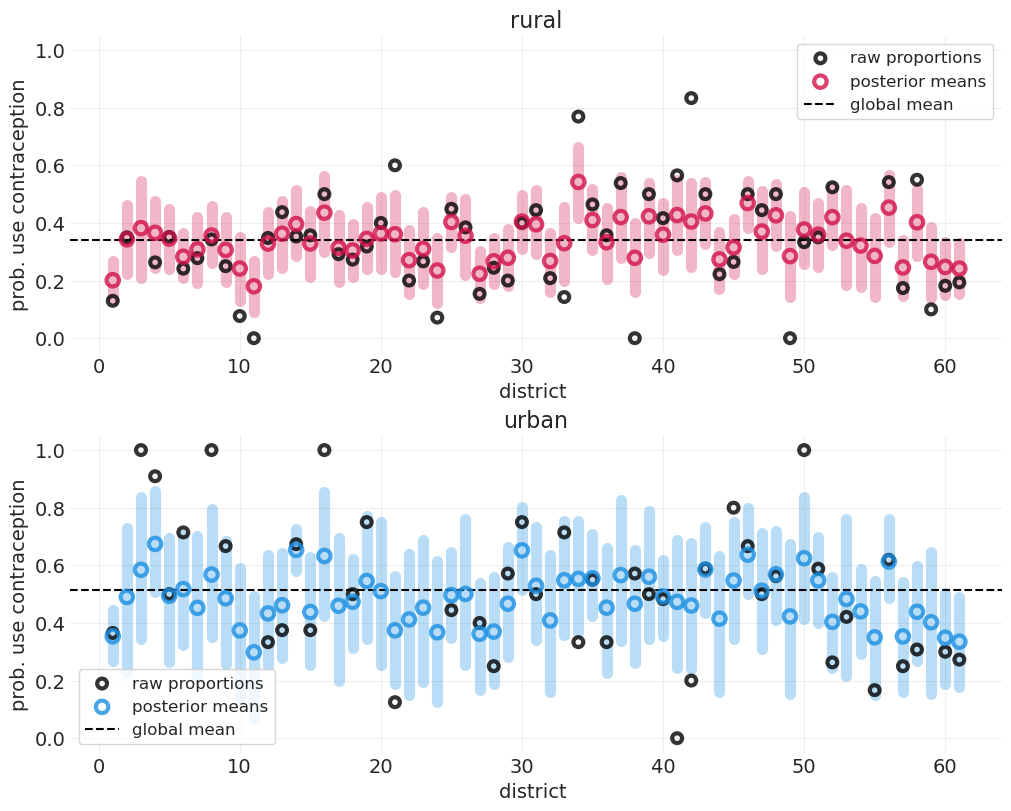

In [15]:
fig, axs = plt.subplots(2, 1, figsize=(10, 8))
for ii, (label, var) in enumerate(zip(['rural', 'urban'], ["p_C_rural", "p_C_urban"])):
    plot_survival_posterior(district_urban_inference, color=f'C{ii}', var=var, data_filter=label, ax=axs[ii])
    plt.title(label)
    
# Save fig for reference in next lecture
utils.savefig("fertility_posterior_means_rural_urban.png")

#### Posterior variances
The plots above indicate that urban areas have
- higher overall rates of contraceptive use
- The error bars higher variance in urban areas

The plot below re-confirms that variance in contraceptive use is indeed larger in urban areas; the posterior standard deviation parameter for urban areas $\tau$ is larger than the parameter $\sigma$ for rural areas

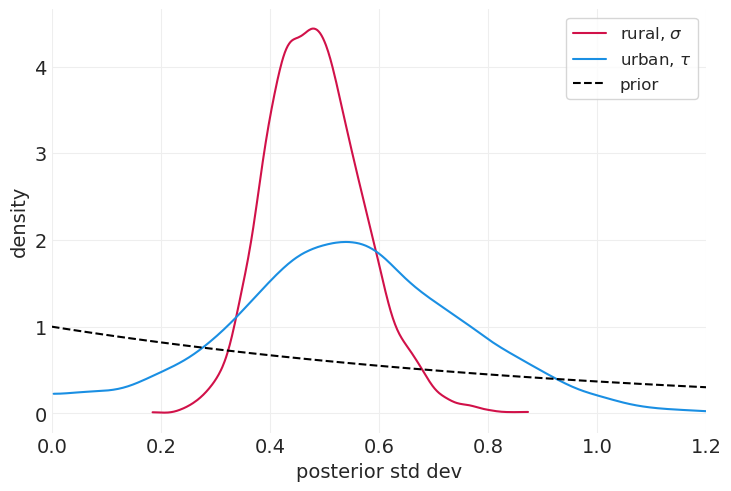

In [16]:
for ii, (label, var) in enumerate(zip(['rural, $\\sigma$', 'urban, $\\tau$'], ['sigma', 'tau'])):
    az.plot_dist(district_urban_inference.posterior[var], color=f"C{ii}", label=label)
    
def exponential_prior(x, lambda_=1):
    return lambda_ * np.exp(-lambda_ * x)

xs = np.linspace(0, 1.2)
plt.plot(xs, exponential_prior(xs), label='prior', color='k', linestyle='--')
plt.xlim([0, 1.2])
plt.xlabel("posterior std dev")
plt.ylabel("density")
plt.legend();

### Urban and Rural Outcomes are positively correlated

saving figure to images/fertility_p_C_rural_urban.png


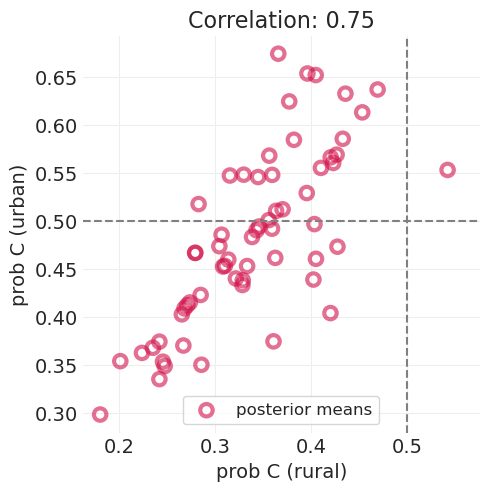

In [17]:
posterior_mean = district_urban_inference.posterior.mean(dim=("chain", "draw"))
utils.plot_scatter(posterior_mean["p_C_rural"], posterior_mean["p_C_urban"], color='C0', label='posterior means')
correlation = np.corrcoef(posterior_mean["p_C_rural"], posterior_mean["p_C_urban"])[0][1]
plt.axvline(.5, color='gray', linestyle='dashed')
plt.axhline(.5, color='gray', linestyle='dashed')
plt.xlabel("prob C (rural)")
plt.ylabel("prob C (urban)")
plt.title(f"Correlation: {correlation:1.2f}")
plt.legend()
plt.axis("square");

# Save fig for reference in next lecture
utils.savefig("fertility_p_C_rural_urban.png");

#### A few observations
- There's more contraceptive use in urban areas than in rural areas--a majority of points are to the left of the vertical line
- There's a high amount of correlation (cc>0.7) between contraceptive use in rural and urban areas in each district.

**We should be able to take advantage of this correlation information to make better estimates**. MORE TO COME!

# Summary: Multilevel Adventures
- **Clusters**: distinct groups in the data
- **Features**: aspects of the model (e.g. parameters) that vary by cluster
- There is useful information transferred across features
  - We can use partial pooling to efficiently estimate features, even in absence of data